<a id="import-data"></a>
## Import Data

# Machine Learning Project

## Table of Contents
- [Import Data](#import-data)
- [Data Exploration](#data-exploration)
  - [Boolean Features](#boolean-features)
  - [Categorical Features](#categorical-features)
  - [Numerical Features](#numerical-features)
    - [Numerical Plots](#numerical-plots)
- [Pre-processing](#pre-processing)
  - [Missing Values](#missing-values)
  - [String Distance](#string-distance)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# to calculate distance between strings
from thefuzz import process, fuzz

In [2]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [4]:
num_duplicated_ids = df.index.duplicated().sum()
print(f'Number of duplicated carIDs: {num_duplicated_ids}')

Number of duplicated carIDs: 0


#### Import Data Summary
- Dataset loaded successfully with `carID` as the index
- There are no duplicate entries in carID
- The dataset contains information about cars including both numerical features (price, mileage, tax, etc.) and categorical features (brand, model, transmission, etc.)
- Initial inspection shows multiple features that will require preprocessing:
  - Numerical features that need cleaning (negative values, outliers)
  - Categorical features that need standardization
  - Presence of missing values in several columns

<a id="data-exploration"></a>
## Data Exploration

<a id="boolean-features"></a>
### Boolean Features

In [5]:
df['hasDamage'].value_counts(dropna=False)

hasDamage
0.0    74425
NaN     1548
Name: count, dtype: int64

#### Boolean Features Analysis

Key observations about `hasDamage` feature:
- Only contains binary values (0) and NaN
- No instances of value 1 found, suggesting potential data collection issues
- May indicate:
  - Cars with damage not being listed
  - System default setting of 0 for non-damaged cars
  - Incomplete damage assessment process
- Requires special handling in preprocessing:
  - Consider treating NaN as a separate category
  - Validate if 0 truly represents "no damage"
  - May need to be treated as a categorical rather than boolean feature

<a id="categorical-features"></a>
### Categorical Features

#### Check Categorical Features Consistency

In [6]:
# List of categorical features
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

# Identify outlier examples in categorical features
cat_outliers_examples = {col: df[col].value_counts().tail(10).index for col in cat_cols}

pd.DataFrame(cat_outliers_examples)

,Brand,model,fuelType,transmission
0,mercede,GOLF SV,Othe,utomati
1,kod,tiguan,ther,manual
2,AUD,CLK,Electric,AUTOMATI
3,KODA,gtc,YBRID,emi-Aut
4,HYUNDA,Gol,OTHER,Other
5,OYOTA,M5,other,semi-aut
6,SKOD,gls class,HYBRI,manua
7,TOYOT,Mokka,ybri,UTOMATIC
8,skod,6 Serie,ETRO,manual
9,toyot,JETTA,IESE,nknow


#### Categorical Features Summary
- Initial analysis reveals significant data quality issues across all categorical columns
- No standardization in categorical features, with multiple variations of the same values (different spellings, capitalizations)
- Solution: We will implement string distance-based standardization using the `thefuzz` library to clean and standardize these features

<a id="numerical-features"></a>
### Numerical Features

In [7]:
# Dict of numerical features
num_cols = {
    'price': 'continuous',
    'mileage': 'continuous',
    'tax': 'continuous',
    'mpg': 'continuous',
    'paintQuality%': 'continuous',
    'engineSize': 'continuous',
    'year': 'discrete',
    'previousOwners': 'discrete'
}

<a id="plots"></a>
#### Numerical Plots

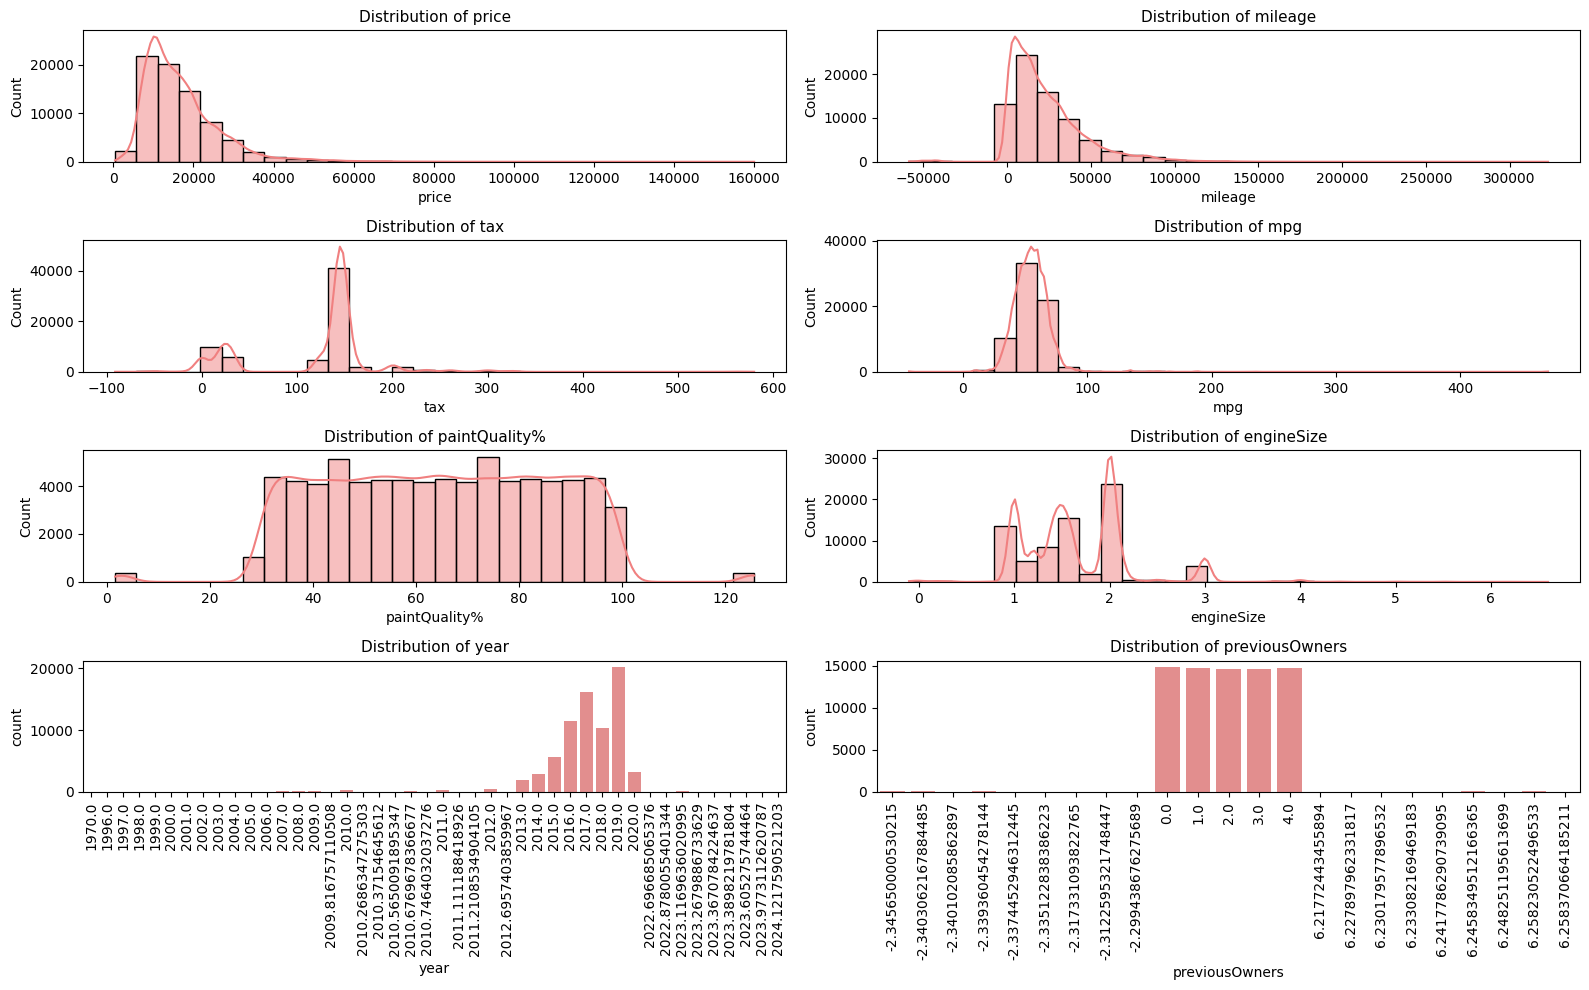

In [8]:
# Plot figures for numerical features and the target variable (price)
plt.figure(figsize=(16, 10))
for i, (col, var_type) in enumerate(num_cols.items(), 1):
    plt.subplot(4, 2, i)

    # Plot based on variable type
    if var_type == 'continuous':
        sns.histplot(data=df, x=col, kde=True, color="lightcoral", bins=30)
        plt.title(f"Distribution of {col}", fontsize=11)
    elif var_type == 'discrete':
        sns.countplot(data=df, x=col, color="lightcoral")
        plt.title(f"Distribution of {col}", fontsize=11)
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

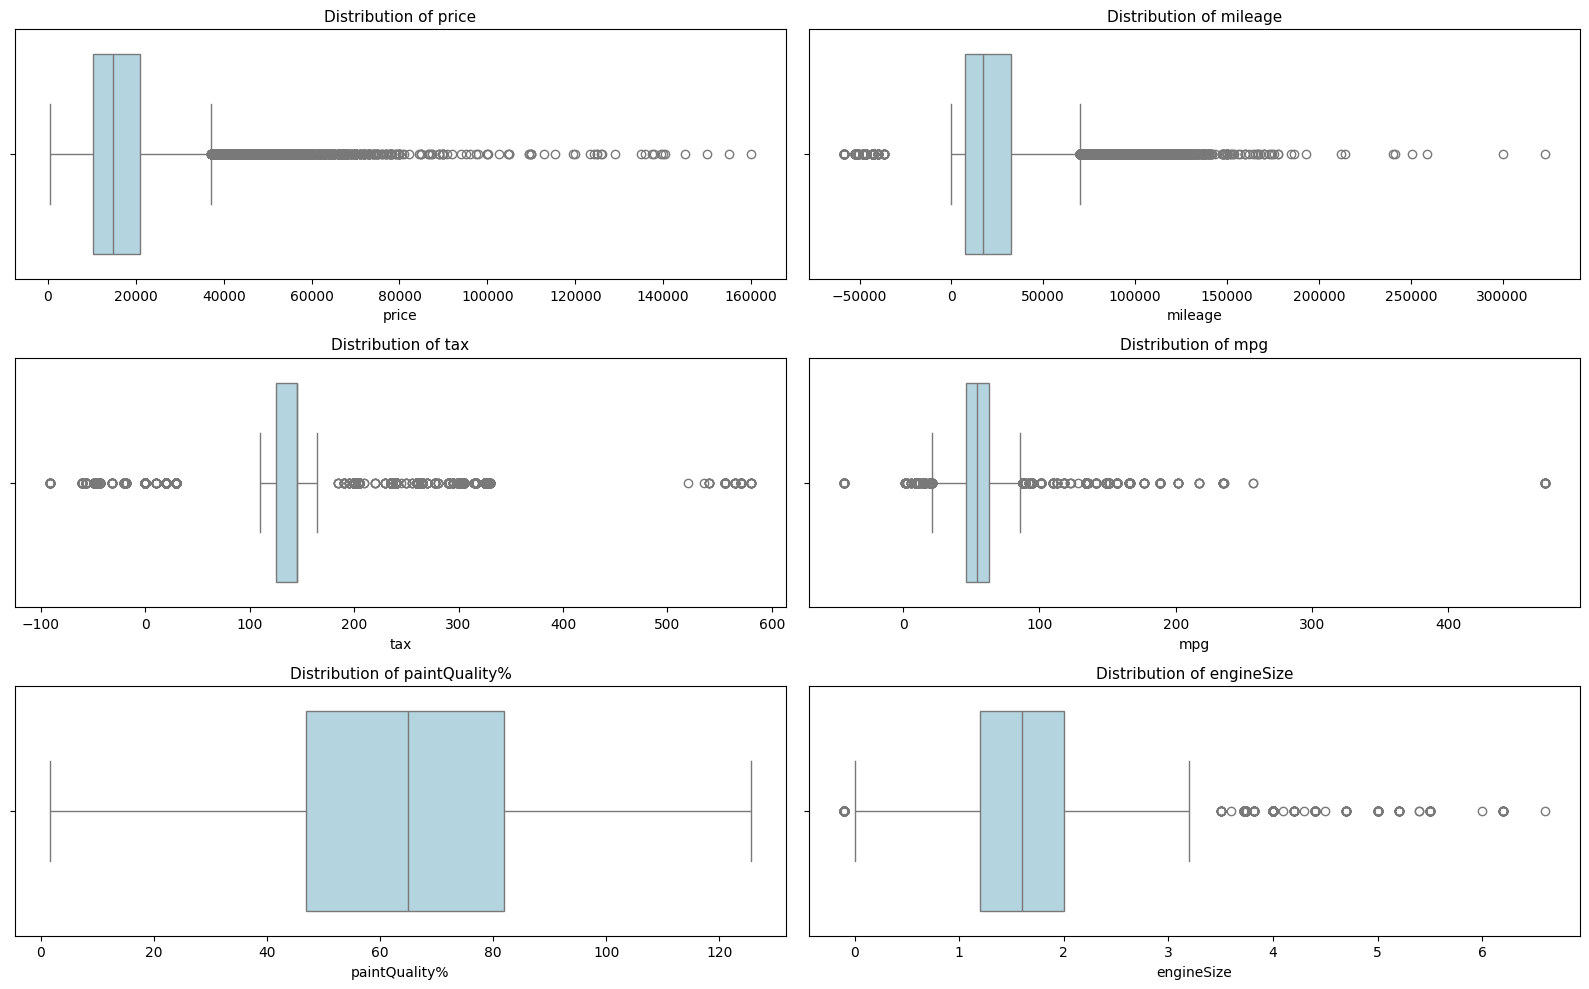

In [9]:
# Boxplots for continuous numerical features and the target variable (price)
continuous_cols = [col for col, var_type in num_cols.items() if var_type == 'continuous']
plt.figure(figsize=(16, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color="lightblue")
    plt.title(f"Distribution of {col}", fontsize=11)

plt.tight_layout()
plt.show()

#### Analysis of Numerical Distributions

Key observations from the plots:
- **Target Variable (Price)**:
  - Highly right-skewed distribution
  - Contains significant number of outliers in the upper range
  - Most cars are concentrated in the lower price range

- **Mileage**:
  - Right-skewed distribution
  - Large range from nearly new cars to high-mileage vehicles
  - Some outliers in upper range suggesting possible data entry errors

- **Tax**:
  - Multiple peaks suggesting different tax bands
  - Contains negative values which require investigation (possible tax benefits/rebates)
  - Large number of outliers on both ends of the distribution

- **MPG (Miles Per Gallon)**:
  - Approximately normal distribution with slight right skew
  - Some unrealistic extreme values that need cleaning
  - Reasonable median around typical car efficiency ranges

- **Paint Quality %**:
  - Contains values above 100% which are logically impossible
  - Left-skewed distribution suggesting optimistic ratings
  - Requires standardization to 0-100 range

- **Engine Size**:
  - Multi-modal distribution indicating common engine sizes
  - Some unusual patterns that need investigation
  - Contains outliers that may represent specialty vehicles

- **Year**:
  - Should be discrete but contains decimal values
  - Most cars are from recent years (2015-2023)
  - Some unrealistic values (pre-1950 or post-2025)

- **Previous Owners**:
  - Should be integer but contains float values
  - Right-skewed distribution as expected
  - Maximum values need validation (unusually high number of previous owners)

<a id="pre-processing"></a>
## Pre-processing

In [10]:
X = df.drop(columns=["price"])   
y = df["price"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (60778, 12)
Validation set size: (15195, 12)


In [11]:
X_train_clean = X_train.copy()
X_val_clean = X_val.copy()

<a id="missing-values"></a>
### Missing Values

In [12]:
num_general = ["tax", "previousOwners", "paintQuality%", "engineSize"]

median_imputer = SimpleImputer(strategy="median")
X_train_clean[num_general] = median_imputer.fit_transform(X_train_clean[num_general])
X_val_clean[num_general] = median_imputer.transform(X_val_clean[num_general])

In [13]:
if "mpg" in X_train_clean.columns and "fuelType" in X_train_clean.columns:
    mpg_group_medians = X_train_clean.groupby("fuelType")["mpg"].median()

    def impute_mpg(row):
        if pd.isnull(row["mpg"]):
            return mpg_group_medians.get(row["fuelType"], X_train_clean["mpg"].median())
        return row["mpg"]

    X_train_clean["mpg"] = X_train_clean.apply(impute_mpg, axis=1)
    X_val_clean["mpg"] = X_val_clean.apply(impute_mpg, axis=1)

In [14]:
cat_general = ["Brand", "model", "transmission", "fuelType"]

mode_imputer = SimpleImputer(strategy="most_frequent")
X_train_clean[cat_general] = mode_imputer.fit_transform(X_train_clean[cat_general])
X_val_clean[cat_general] = mode_imputer.transform(X_val_clean[cat_general])

In [15]:
if "hasDamage" in X_train_clean.columns:
    X_train_clean["hasDamage"] = X_train_clean["hasDamage"].fillna("Unknown")
    X_val_clean["hasDamage"] = X_val_clean["hasDamage"].fillna("Unknown")

In [16]:
missing_summary_train = X_train_clean.isnull().sum()
missing_summary_val = X_val_clean.isnull().sum()

print("Remaining missing values (train):", missing_summary_train.sum())
print("Remaining missing values (validation):", missing_summary_val.sum())

Remaining missing values (train): 2359
Remaining missing values (validation): 596


In [17]:
remaining_missing = X_train_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining NaN values:")
display(remaining_missing)

Columns with remaining NaN values:


year       1200
mileage    1158
mpg           1
dtype: int64

In [18]:
for col in ["year", "mileage", "mpg"]:
    if col in X_train_clean.columns:
        median_value = X_train_clean[col].median()
        X_train_clean[col].fillna(median_value, inplace=True)
        X_val_clean[col].fillna(median_value, inplace=True)

remaining_missing = X_train_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining NaN values after final cleaning:")
display(remaining_missing)

Columns with remaining NaN values after final cleaning:


C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\3648844205.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean[col].fillna(median_value, inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\3648844205.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Series([], dtype: int64)

In [19]:
remaining_missing = X_train_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining NaN values:")
display(remaining_missing)

Columns with remaining NaN values:


Series([], dtype: int64)

### Numeric Features

- carID
- year
- price
- mileage
- tax
- mpg
- engineSize
- paintQuality
- previousOwners
- hasDamage


In [20]:
#Check if there are negative features that should not be negative
numeric_features = X_train_clean.select_dtypes(include=['int64', 'float64']).columns
negative_values = {}
for col in numeric_features:
    negative_count = (X_train_clean[col] < 0).sum()
    if negative_count > 0:
        negative_values[col] = negative_count   

for v in negative_values:
    print(f"Feature '{v}' has {negative_values[v]} negative values.")

Feature 'mileage' has 305 negative values.
Feature 'tax' has 294 negative values.
Feature 'mpg' has 28 negative values.
Feature 'engineSize' has 73 negative values.
Feature 'previousOwners' has 289 negative values.


### Strategy:

- Change negative values to `NaN`
- Remove extreme outliers
- Impute using the appropriate method (median, mode, or group-based)
- Convert the column back to integer type if applicable

Note: Still have to choose what method to use to change the missing values in the feature "hasDamage" before I can switch from float to int

In [21]:
cols_to_fix = list(negative_values.keys())

for feature in cols_to_fix:
    X_train_clean.loc[X_train_clean[feature] < 0, feature] = np.nan
    X_val_clean.loc[X_val_clean[feature] < 0, feature] = np.nan


In [22]:
for col in X_train_clean.select_dtypes(include=['int64', 'float64']).columns:
    q1 = X_train_clean[col].quantile(0.25)
    q3 = X_train_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower_lim = q1 - (1.5 * iqr)
    upper_lim = q3 + (1.5 * iqr)
    X_train_clean[col] = X_train_clean[col].mask((X_train_clean[col] < lower_lim) | (X_train_clean[col] > upper_lim), np.nan)
    X_val_clean[col] = X_val_clean[col].mask((X_val_clean[col] < lower_lim) | (X_val_clean[col] > upper_lim), np.nan)


In [23]:
for feature in cols_to_fix:
    median_value = X_train_clean[feature].median()
    X_train_clean[feature].fillna(median_value, inplace=True)
    X_val_clean[feature].fillna(median_value, inplace=True)


C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\1560256754.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean[feature].fillna(median_value, inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\1560256754.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [24]:
int_cols = ['year', 'previousOwners']

median_year = X_train_clean['year'].median()
X_train_clean['year'].fillna(median_year, inplace=True)
X_val_clean['year'].fillna(median_year, inplace=True)

for feature in int_cols:
    X_train_clean[feature] = X_train_clean[feature].astype(int)
    X_val_clean[feature] = X_val_clean[feature].astype(int)

C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\150842670.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean['year'].fillna(median_year, inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\150842670.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [25]:
(X_train_clean["year"] < 1950).sum() and (X_train_clean["year"] > 2025).sum()

np.int64(0)

In [26]:
X_train_clean.head()


,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
17712,Ford,Fiesta,2018,Manual,25943.0,Petrol,145.0,65.7,1.0,34.0,1,0.0
60272,Opel,Mokka X,2018,unknow,28993.0,Petrol,145.0,47.1,1.4,60.0,4,0.0
54409,Toyota,Yaris,2014,automatic,66158.0,Hybrid,145.0,76.3,1.5,97.0,1,0.0
60966,Opel,Corsa,2017,Manual,22759.0,Petrol,145.0,55.4,1.4,69.0,2,0.0
2891,Audi,Q3,2018,Semi-Auto,4847.0,Petrol,145.0,40.4,2.0,51.0,4,0.0


In [27]:
X_val_clean.head()

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
44722,Mercedes,GLC Class,2018,Automatic,9500.0,Diesel,150.0,56.5,2.1,77.0,0,Unknown
35963,Mercedes,C Class,2017,Automatic,50369.0,Diesel,145.0,65.7,2.1,80.0,4,0.0
50618,Skoda,Citigo,2017,manual,7489.0,Petrol,150.0,64.2,1.0,84.0,4,0.0
69344,VW,Touareg,2019,Automatic,7000.0,Diesel,145.0,34.0,3.0,62.0,0,0.0
26815,Ford,Focus,2019,Manual,10812.0,DIESEL,145.0,60.1,1.5,99.0,2,0.0


Final check for nan values

In [28]:
X_train_clean.isnull().sum()

Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64

Check for other strange values

In [29]:
X_train_clean.loc[(X_train_clean['paintQuality%'] > 100), 'paintQuality%'] = np.nan
X_val_clean.loc[(X_val_clean['paintQuality%'] > 100), 'paintQuality%'] = np.nan

median_paint = X_train_clean['paintQuality%'].median()
X_train_clean['paintQuality%'].fillna(median_paint, inplace=True)
X_val_clean['paintQuality%'].fillna(median_paint, inplace=True)



C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\567158984.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean['paintQuality%'].fillna(median_paint, inplace=True)
C:\Users\lucas\AppData\Local\Temp\ipykernel_19616\567158984.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [30]:
missing_counts = X_train_clean.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent.round(2)
}).sort_values(by="Missing %", ascending=False)

missing_summary[missing_summary["Missing Count"] > 0]

,Missing Count,Missing %


In [31]:
num_cols = X_train_clean.select_dtypes(include=["int64", "float64"]).columns

outlier_summary = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train_clean[(X_train_clean[col] < lower_bound) | (X_train_clean[col] > upper_bound)]
    
    outlier_summary.append({
        "Feature": col,
        "Lower Bound": round(lower_bound, 2),
        "Upper Bound": round(upper_bound, 2),
        "Outlier Count": len(outliers),
        "Outlier %": round(len(outliers) / len(df) * 100, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values(by="Outlier %", ascending=False)
outlier_df

,Feature,Lower Bound,Upper Bound,Outlier Count,Outlier %
0,year,2011.50,2023.50,0,0.0
1,mileage,-30083.12,69933.88,0,0.0
2,tax,95.00,175.00,0,0.0
3,mpg,21.55,87.55,0,0.0
4,engineSize,-0.00,3.20,0,0.0
5,paintQuality%,-5.50,134.50,0,0.0
6,previousOwners,-2.00,6.00,0,0.0


<a id="string-distances"></a>
# Calculating the string distances
to standardize the column strings that have misspelled names using the library "thefuzz"

First we are standarlizing the brands

In [32]:
X_train_clean

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
17712,Ford,Fiesta,2018,Manual,25943.0,Petrol,145.0,65.7,1.0,34.0,1,0.0
60272,Opel,Mokka X,2018,unknow,28993.0,Petrol,145.0,47.1,1.4,60.0,4,0.0
54409,Toyota,Yaris,2014,automatic,66158.0,Hybrid,145.0,76.3,1.5,97.0,1,0.0
60966,Opel,Corsa,2017,Manual,22759.0,Petrol,145.0,55.4,1.4,69.0,2,0.0
2891,Audi,Q3,2018,Semi-Auto,4847.0,Petrol,145.0,40.4,2.0,51.0,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41593,Mercedes,C Class,2019,Semi-Auto,3668.0,Petro,145.0,51.4,3.0,84.0,4,0.0
19620,Ford,Kuga,2019,Automatic,11559.0,Diesel,145.0,37.7,2.0,71.0,2,0.0
66650,VW,Tiguan,2016,Manual,62000.0,Diesel,125.0,58.9,2.0,80.0,4,0.0


In [33]:

brands = ["volkswagen", "ford", "fiat", "volksvagen", "wolkswagen"]


In [34]:
BRAND_COL = "Brand"   
ANCHOR_NUM = 9            # top 10 k most frequent ancor
SIM_THRESHOLD = 85

# threshold for fuzzy matching
SIM_THRESHOLD = 85

In [35]:
_brand_norm = X_train_clean[BRAND_COL].astype(str)   # make it shure that is a string
_brand_norm = _brand_norm.str.strip()                # remove extra spaces
_brand_norm = _brand_norm.str.lower()                # to lower case

df["Brand"].str.lower().value_counts() #analysing the most frequent brand names in our datasety

Brand
ford        15431
mercedes    11209
vw           9973
opel         8979
bmw          7102
audi         7028
toyota       4455
skoda        4138
hyundai      3201
ord           320
for           305
ercedes       236
mercede       222
w             208
v             204
ope           188
pel           181
mw            149
aud           147
udi           147
bm            141
oyota          93
koda           82
skod           81
toyot          74
yundai         68
hyunda         64
ercede          7
or              7
pe              4
yunda           3
ud              3
kod             2
Name: count, dtype: int64

Now we get the most common brand names as we analysed before and create a map dictionary for corrections

In [36]:
anchors = _brand_norm.value_counts().head(ANCHOR_NUM).index.tolist()
anchors

['ford', 'mercedes', 'vw', 'opel', 'bmw', 'audi', 'toyota', 'skoda', 'hyundai']

In [37]:


mapping = {}

# for each unique brand, find the closest anchor and map if similarity is high
for val in _brand_norm.unique():
    if val in anchors:
        continue  # already a good brand
    match, score = process.extractOne(val, anchors, scorer=fuzz.token_set_ratio)
    if score >= SIM_THRESHOLD:
        mapping[val] = match  # map wrong/rare brand to correct one

In [38]:
X_train_clean["brand_clean"] = _brand_norm.map(lambda x: mapping.get(x, x))

In [39]:
mapping

{'ord': 'ford',
 'udi': 'audi',
 'for': 'ford',
 'aud': 'audi',
 'ercedes': 'mercedes',
 'ope': 'opel',
 'mercede': 'mercedes',
 'oyota': 'toyota',
 'pel': 'opel',
 'toyot': 'toyota',
 'skod': 'skoda',
 'hyunda': 'hyundai',
 'koda': 'skoda',
 'ercede': 'mercedes',
 'yundai': 'hyundai'}

In [40]:
X_train_clean["brand_clean"]

carID
17712        ford
60272        opel
54409      toyota
60966        opel
2891         audi
           ...   
41593    mercedes
19620        ford
66650          vw
49062       skoda
49075       skoda
Name: brand_clean, Length: 60778, dtype: object